# Back to the Dataset

Let's have a look (e.g.) at the distribution of the number zombies:

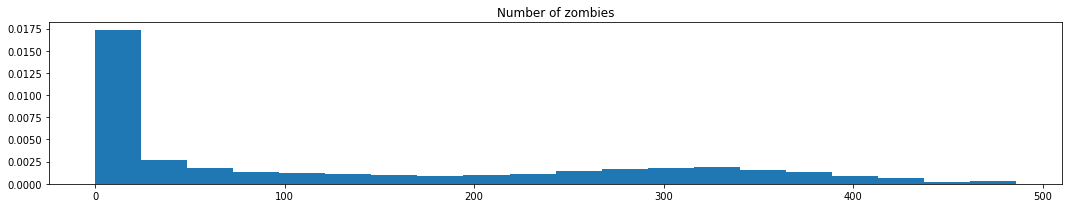

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

# Load data
data_fname = os.path.join('data', 'za_data.csv')
data = pd.read_csv(data_fname)

# Some meta-information
sim_in = ['edge_ratio', 'inf_prob', 'act_rate', 'rec_rate', 'ds_rate', 'di_rate']
sim_out = ['i_num', 'survivors']
n_in = len(sim_in)
n_out = len(sim_out)
in_defaults = [0.004, 0.7, 3, 0, 0.05, 0.00]
pop_size = 500

# Compute a new column (number of survivors)
data['survivors'] = data['s_num'] + data['r_num']

# Plot a a few distribution
nbins = 20
plt.figure(figsize=(15, 3))
plt.title('Number of zombies')
plt.hist(data.i_num, bins=nbins, density=True)
plt.tight_layout()

This is actually heavy tailed! It means that, even if it is very likely that the zombies are few, there is also a non-negligible chance that their number swell beyond control.

We can somehow mitigate this by changing the way we aggregate simulator outputs, matching the way we will use that information in the optimization problem. In particular:

* Few survivors are a bad thing that we want to avoid, so we can focus on the *minimum* number of survivors for each input configuration
* Many zombies are a bad thing that we want to avoid, so we can focus on the *maximum* number of survivors for each input configuration

In [3]:
# Aggregate + split into training, validation, and test data
data_tr = []
data_vl = []
data_ts = []
for lbl, gdata in data.groupby(sim_in):
    lnum = len(gdata)
    sep1 = int(lnum * 2/3)
    sep2 = int(lnum * 5/6)
    gdata_tr = gdata.iloc[:sep1]
    gdata_vl = gdata.iloc[sep1:sep2]
    gdata_ts = gdata.iloc[sep2:]
    data_tr.append(lbl + (gdata_tr['i_num'].max(),) + (gdata_tr['survivors'].min(),))
    data_vl.append(lbl + (gdata_vl['i_num'].max(),) + (gdata_vl['survivors'].min(),))
    data_ts.append(lbl + (gdata_ts['i_num'].max(),) + (gdata_ts['survivors'].min(),))
    
data_tr = pd.DataFrame(data=data_tr, columns=sim_in + sim_out)
data_vl = pd.DataFrame(data=data_vl, columns=sim_in + sim_out)
data_ts = pd.DataFrame(data=data_ts, columns=sim_in + sim_out)

Then we need to standardize and store as usual:

In [4]:
# Standardize inputs
means_in = data_tr[sim_in].mean(axis=0)
stds_in = data_tr[sim_in].std(axis=0)
data_tr[sim_in] = (data_tr[sim_in] - means_in) / stds_in
data_vl[sim_in] = (data_vl[sim_in] - means_in) / stds_in
data_ts[sim_in] = (data_ts[sim_in] - means_in) / stds_in

# Standardize output
data_tr[sim_out] /= pop_size
data_vl[sim_out] /= pop_size
data_ts[sim_out] /= pop_size

# Store into an HDF5 archive
hdf_fname = os.path.join('shared', 'za_processed.h5')
with pd.HDFStore(hdf_fname, 'w') as store:
    store['data'] = data
    store['data_tr'] = data_tr
    store['data_vl'] = data_vl
    store['data_ts'] = data_ts
    store['means_in'] = means_in
    store['stds_in'] = stds_in
    store['sim_in'] = pd.Series(sim_in)
    store['sim_out'] = pd.Series(sim_out)
    store['in_defaults'] = pd.Series(index=sim_in, data=in_defaults)
    store['meta'] = pd.Series(index=['pop_size'], data=[pop_size])

## Training Again

And then we need to train out networks again:

In [5]:
import numpy as np
import keras
import pandas as pd
import os

# Separate input and output
X_tr = data_tr[sim_in]
Y_tr = data_tr[sim_out]
X_vl = data_vl[sim_in]
Y_vl = data_vl[sim_out]
X_ts = data_ts[sim_in]
Y_ts = data_ts[sim_out]

First the scalar outpt networks:

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import tensorflow
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Seed the RNGs
np.random.seed(42)
tensorflow.set_random_seed(42)

# Custom R2 metric (courtesy of https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019)
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Input shape
input_shape = (X_tr.shape[1],)

# Handle outputs
max_epochs = 50
for target in sim_out:
    y_tr = Y_tr[target].values
    y_vl = Y_vl[target].values
    y_ts = Y_ts[target].values

    # Define a Neural Network model to predict the number of infected
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=[r2_score])

    # Setup and perform training
    weight_fname = os.path.join('shared', 'nn_reg_%s.h5' % target)
    callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                 ModelCheckpoint(filepath=weight_fname, monitor='val_loss', save_best_only=True)]
    model.fit(X_tr, y_tr, epochs=max_epochs, batch_size=32, callbacks=callbacks,
              validation_data=(X_vl, y_vl), verbose=0)
    
    # Save the model architecture
    arch_fname = os.path.join('shared', 'nn_reg_%s.json' % target)
    with open(arch_fname, 'w') as fp:
        fp.write(model.to_json())

    # Evaluate on the test set
    print('=== Results for target "{}"'.format(target))
    res_tr = model.evaluate(X_tr, y_tr, batch_size=len(X_tr))
    print('Loss and R2 on the training set: {}, {}'.format(*res_tr))
    res_vl = model.evaluate(X_vl, y_vl, batch_size=len(X_vl))
    print('Loss and R2 on the validation set: {}, {}'.format(*res_vl) )
    res_ts = model.evaluate(X_ts, y_ts, batch_size=len(X_ts))
    print('Loss and R2 on the test set: {}, {}'.format(*res_ts))

=== Results for target "i_num"
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the training set: 0.0018747192807495594, 0.9764277935028076
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the validation set: 0.007005876395851374, 0.9152546525001526
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the test set: 0.00708514591678977, 0.9136992692947388
=== Results for target "survivors"
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the training set: 0.0022607441060245037, 0.9768103361129761
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the validation set: 0.00894516333937645, 0.9137647151947021
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the test set: 0.009159809909760952, 0.911647379398346


And then the one with vector output:

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import tensorflow
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Seed the RNGs
np.random.seed(42)
tensorflow.set_random_seed(42)

# Custom R2 metric (courtesy of https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019)
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Input shape
input_shape = (X_tr.shape[1],)

# Both outputs at the same time
max_epochs = 50

# Define a Neural Network model to predict the number of infected
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=input_shape))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='linear'))

# Compile
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=[r2_score])

# Setup and perform training
weight_fname = os.path.join('shared', 'nn_reg.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath=weight_fname, monitor='val_loss', save_best_only=True)]
model.fit(X_tr, Y_tr, epochs=max_epochs, batch_size=32, callbacks=callbacks,
          validation_data=(X_vl, Y_vl), verbose=0)

# Save the model architecture
arch_fname = os.path.join('shared', 'nn_reg.json')
with open(arch_fname, 'w') as fp:
    fp.write(model.to_json())

# Evaluate on the test set
res_tr = model.evaluate(X_tr, Y_tr, batch_size=len(X_tr))
print('Loss and R2 on the training set: {}, {}'.format(*res_tr))
res_vl = model.evaluate(X_vl, Y_vl, batch_size=len(X_vl))
print('Loss and R2 on the validation set: {}, {}'.format(*res_vl) )
res_ts = model.evaluate(X_ts, Y_ts, batch_size=len(X_ts))
print('Loss and R2 on the test set: {}, {}'.format(*res_ts))

1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the training set: 0.0023636450059711933, 0.9734442830085754
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the validation set: 0.007418295834213495, 0.9208840131759644
1620/1620 [==============================] - 0s 1us/step
Loss and R2 on the test set: 0.0076693822629749775, 0.9179416298866272
